# III. Prédiction de l'émission de gaz à effet de serre

## 1. Importation des modules et des jeux de données

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,Normalizer,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.svm import LinearSVR, SVR
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor

# 1. Prédiction  de l'émission de CO2 en présence de ENERGYSTARScore

In [3]:
# Import the dataset with ENERGYSTARScore
seattle_data = pd.read_csv("with_energystarscore.csv")
seattle_data.sample(5)

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
710,1.0,2,47560,0,47560,23146.0,80.000000,24.000000,25.900000,51.099998,53.099998,1.132490e+06,1.221954e+06,0.00000,1.709542e+05,583296.0,5491.938477,549194.0,33.23,0.70
198,1.0,10,693450,0,693450,361107.0,93.000000,57.799999,57.700001,173.699997,173.600006,4.006289e+07,4.003774e+07,21230.80078,1.098976e+07,37497068.0,25445.839840,2544584.0,398.19,0.57
989,1.0,1,41895,0,41895,37524.0,35.397814,31.000000,33.500000,78.699997,81.000000,1.242312e+06,1.343671e+06,0.00000,2.597369e+05,886222.0,3560.890137,356089.0,25.09,0.60
838,1.0,3,25262,0,25262,25262.0,54.000000,58.200001,59.700001,158.300003,159.899994,1.469556e+06,1.508578e+06,0.00000,3.442773e+05,1174674.0,2948.820068,294882.0,23.85,0.94
816,1.0,6,46580,0,46580,46580.0,51.479902,15.200000,16.700001,47.900002,52.500000,7.102754e+05,7.787021e+05,0.00000,2.081698e+05,710275.0,0.000000,0.0,4.95,0.11


In [4]:
seattle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1693 entries, 0 to 1692
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   NumberofBuildings          1693 non-null   float64
 1   NumberofFloors             1693 non-null   int64  
 2   PropertyGFATotal           1693 non-null   int64  
 3   PropertyGFAParking         1693 non-null   int64  
 4   PropertyGFABuilding(s)     1693 non-null   int64  
 5   LargestPropertyUseTypeGFA  1693 non-null   float64
 6   ENERGYSTARScore            1693 non-null   float64
 7   SiteEUI(kBtu/sf)           1693 non-null   float64
 8   SiteEUIWN(kBtu/sf)         1693 non-null   float64
 9   SourceEUI(kBtu/sf)         1693 non-null   float64
 10  SourceEUIWN(kBtu/sf)       1693 non-null   float64
 11  SiteEnergyUse(kBtu)        1693 non-null   float64
 12  SiteEnergyUseWN(kBtu)      1693 non-null   float64
 13  SteamUse(kBtu)             1693 non-null   float

### Mise en échelle des variables 

In [5]:
# Standard scaling the predictor columns
# scale features
seattle_data_model = seattle_data.copy()
scaler = StandardScaler()
seattle_data_model.loc[:,seattle_data_model.select_dtypes(include=[np.number]).columns.tolist()] = scaler.fit_transform(seattle_data_model.loc[:,seattle_data_model.select_dtypes(include=[np.number]).columns.tolist()])

### Variables d'entrainement et variables cibles

In [6]:
# Energy dataset without transformation of SiteEnergyUse(kBtu) target
seattle_ges_target = pd.DataFrame(np.log1p(seattle_data_model["TotalGHGEmissions"]))
seattle_ges_predictors = seattle_data_model.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions',
                                                       "SiteEnergyUseWN(kBtu)","GHGEmissionsIntensity"], axis=1)

### train/test split

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(seattle_ges_predictors, seattle_ges_target, test_size=0.3,random_state=33)

print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)

X_train (1185, 16)
y_train (1185, 1)
X_test (508, 16)
y_test (508, 1)


### Regression linéaire

In [8]:
# Regression object
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [9]:
# Prediction score(coefficient of determination of the model)
r2_score_lin = lin_model.score(X_test, y_test)
print(f"The coefficient of determination of the model is : {lin_model.score(X_test, y_test)}") 

The coefficient of determination of the model is : 0.4267810989783186


In [10]:
# Predicted values
y_pred = lin_model.predict(X_test)

# RMSE est une mesure relative qui va dépendre de la valeur de la variable cible. Obtenir 2 RMSE différentes pour 2 sets 
    # de données et donc pour 2 modèles différents ne permet pas de conclure.
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_lin

0.268311429421492

In [11]:
# MAPE est une mesure relative mais indépendante de l'amplitude de la variable cible, donc une MAPE plus petite veut bien
 # dire un meilleur modèle.
mape_lin = mean_absolute_percentage_error(y_test, y_pred)
mape_lin

1.1765502383194593

Text(0.5, 1.0, 'Ajustement du modèle LinearRegression')

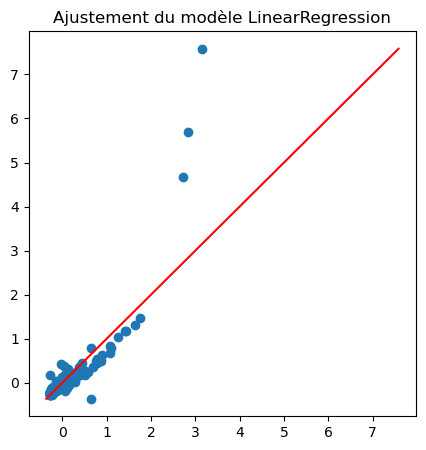

In [12]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
xmax = max(max(y_pred), max(np.array(y_test)))
xmin = min(min(y_pred), min(np.array(y_test)))
plt.plot([xmax, xmin], [xmax, xmin],'r')
plt.title(f"Ajustement du modèle {type(lin_model).__name__}")

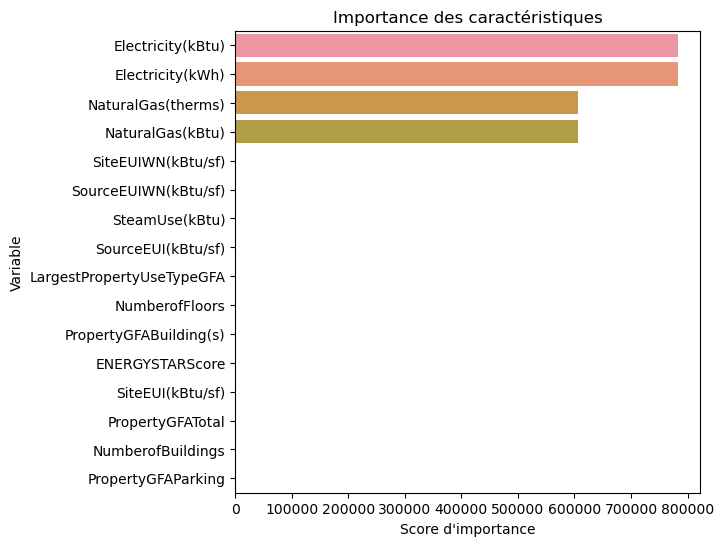

In [13]:
# perform permutation importance and get importance :
# Permutation feature importance is a model inspection technique that measures the contribution of each feature to a 
    # fitted model’s statistical performance on a given tabular dataset.
importance_scores = permutation_importance(lin_model, X_test, y_test, scoring='neg_mean_absolute_percentage_error').importances_mean

# Feature importance plot

feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score d'importance"] = []

for column,score in zip(X_train.columns,importance_scores):
    feature_importance_dict["Variable"].append(column)
    feature_importance_dict["Score d'importance"].append(score)

model_feature_importance = pd.DataFrame(feature_importance_dict).sort_values(by="Score d'importance",ascending=False)


plt.figure(figsize=(6,6))
plt.title("Importance des caractéristiques")
sns.barplot(y = model_feature_importance["Variable"],x=model_feature_importance["Score d'importance"])
plt.show()

### Gridsearch avec la classe RandomForestRegressor

In [14]:
# Set of parameters
params = {
    # Number of trees decision
    'n_estimators' : [10,50,100,150,200], 
    # Minimum number of leaves in a node
    'min_samples_leaf' : [1,3,5,10], 
    # number of features observed for each tree
    'max_features': ['auto', 'sqrt'] 
}

# GridSearchCV class with RandomForestRegressor
grid_rf=GridSearchCV(RandomForestRegressor(),param_grid=params,cv=5)

grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 150, 200]})

In [15]:
# R^2 score : The accurency of the model
r2_rf = grid_rf.score(X_test, y_test)
r2_rf

0.9151217950797791

In [16]:
# Predicted values
y_pred = grid_rf.predict(X_test)
# RMSE est une mesure relative qui va dépendre de la valeur de la variable cible. Obtenir 2 RMSE différentes pour 2 sets 
    # de données et donc pour 2 modèles différents ne permet pas de conclure.
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_rf

0.1032468986151981

In [17]:
# MAPE est une mesure relative mais indépendante de l'amplitude de la variable cible, donc une MAPE plus petite veut bien
 # dire un meilleur modèle.
mape_rf = mean_absolute_percentage_error(y_test, y_pred)
mape_rf

0.3062766266026566

Text(0.5, 1.0, 'Ajustement du modèle GridSearchCV')

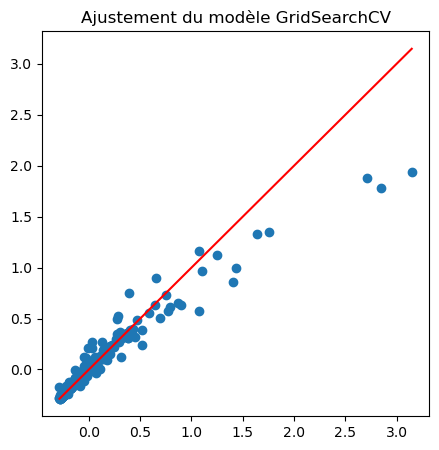

In [18]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
xmax = max(max(y_pred), max(np.array(y_test)))
xmin = min(min(y_pred), min(np.array(y_test)))
plt.plot([xmax, xmin], [xmax, xmin],'r')
plt.title(f"Ajustement du modèle {type(grid_rf).__name__}")

In [19]:
# Best estimator
grid_rf.best_estimator_

RandomForestRegressor(max_features='sqrt', n_estimators=200)

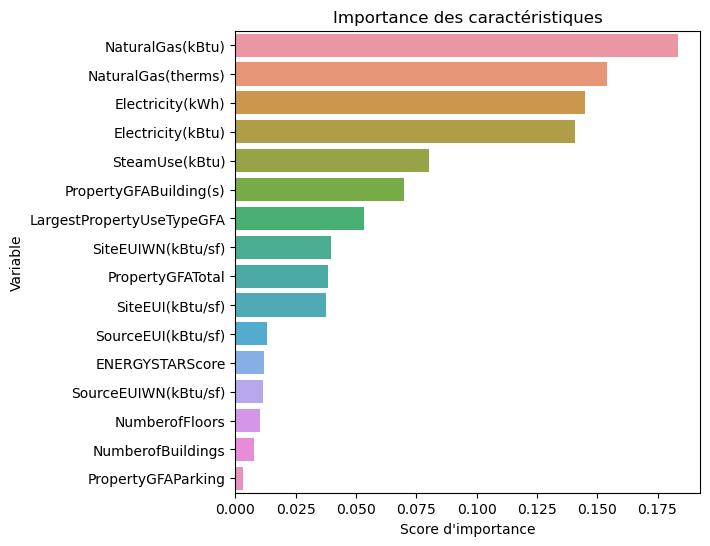

In [20]:
# Feature importance plot

feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score d'importance"] = []

for column,score in zip(X_train.columns,grid_rf.best_estimator_.feature_importances_):
    feature_importance_dict["Variable"].append(column)
    feature_importance_dict["Score d'importance"].append(score)

rf_feature_importance = pd.DataFrame(feature_importance_dict).sort_values(by="Score d'importance",ascending=False)

# Plot feature imporrtance
plt.figure(figsize=(6,6))
plt.title("Importance des caractéristiques")
sns.barplot(y = rf_feature_importance["Variable"],x=rf_feature_importance["Score d'importance"])
plt.show()

### GridSearchCV avec Support Vector Machine

In [21]:
# Set of parameters
params={
    # kernel coefficient 
    "gamma" : [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1], 
    # error tolerated by the algorithm
    "epsilon" : [0.001, 0.01, 0.1, 1], 
    # Regularization parameter
    "C" : [0.001, 0.01, 0.1, 1, 10]
}

svm_model = GridSearchCV(estimator=SVR(),param_grid=params,cv=5)

svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'epsilon': [0.001, 0.01, 0.1, 1],
                         'gamma': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001,
                                   0.01, 0.1]})

In [22]:
# The coefficient of determination of the prediction.
r2_svr = svm_model.score(X_test,y_test)
r2_svr

0.7784221674914906

In [23]:
# make predictions on the data 
y_pred = svm_model.predict(X_test)

# RMSE est une mesure relative qui va dépendre de la valeur de la variable cible. Obtenir 2 RMSE différentes pour 2 sets 
    # de données et donc pour 2 modèles différents ne permet pas de conclure.
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_svr

0.1668176799107562

In [24]:
# MAPE est une mesure relative mais indépendante de l'amplitude de la variable cible, donc une MAPE plus petite veut bien
 # dire un meilleur modèle.
mape_svr = mean_absolute_percentage_error(y_test, y_pred)
mape_svr

0.18245280020524676

Text(0.5, 1.0, 'Ajustement du modèle GridSearchCV')

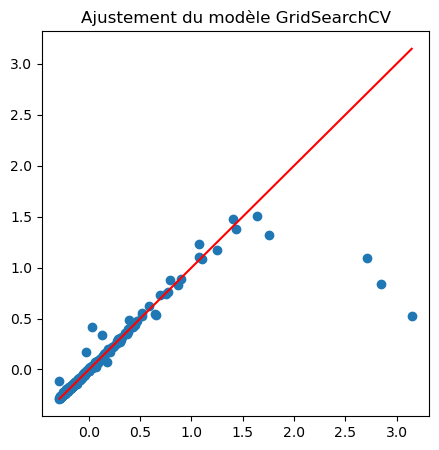

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
xmax = max(max(y_pred), max(np.array(y_test)))
xmin = min(min(y_pred), min(np.array(y_test)))
plt.plot([xmax, xmin], [xmax, xmin],'r')
plt.title(f"Ajustement du modèle {type(svm_model).__name__}")

In [26]:
# Best estimator
svm_model.best_estimator_

SVR(C=10, epsilon=0.01, gamma=0.01)

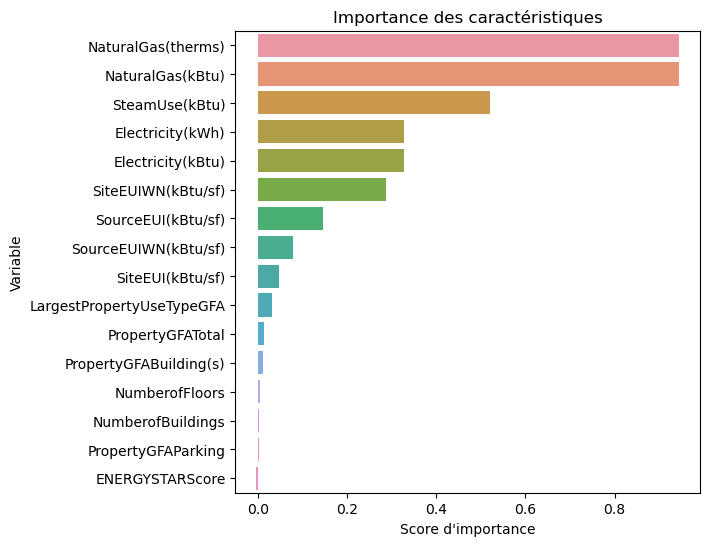

In [27]:
# perform permutation importance and get importance
importance_scores = permutation_importance(svm_model, X_test, y_test, scoring='neg_mean_absolute_percentage_error').importances_mean

# Feature importance plot

feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score d'importance"] = []

for column,score in zip(X_train.columns,importance_scores):
    feature_importance_dict["Variable"].append(column)
    feature_importance_dict["Score d'importance"].append(score)

model_feature_importance = pd.DataFrame(feature_importance_dict).sort_values(by="Score d'importance",ascending=False)


plt.figure(figsize=(6,6))
plt.title("Importance des caractéristiques")
sns.barplot(y = model_feature_importance["Variable"],x=model_feature_importance["Score d'importance"])
plt.show()

###  Xgboost

In [28]:
params = {'n_estimators' : [100,200,300,400,500,600,700]}
boosting_model = GridSearchCV(XGBRegressor(),param_grid=params,cv=5)
boosting_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'n_estimators': [100, 200, 300, 400, 500, 600, 700]})

In [29]:
# The coefficient of determination of the prediction.
r2_xgb = boosting_model.score(X_test,y_test)
r2_xgb

0.9221824394012489

In [30]:
# make predictions on the data 
y_pred = boosting_model.predict(X_test)

# RMSE est une mesure relative qui va dépendre de la valeur de la variable cible. Obtenir 2 RMSE différentes pour 2 sets 
    # de données et donc pour 2 modèles différents ne permet pas de conclure.
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_xgb

0.09885934488085893

In [31]:
# MAPE est une mesure relative mais indépendante de l'amplitude de la variable cible, donc une MAPE plus petite veut bien
 # dire un meilleur modèle.
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
mape_xgb

0.17193969966839664

Text(0.5, 1.0, 'Ajustement du modèle XGBRegressor')

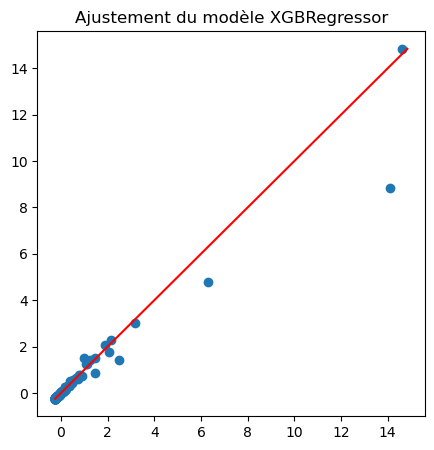

In [86]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
xmax = max(max(y_pred), float(max(np.array(y_test))))
xmin = min(min(y_pred), float(min(np.array(y_test))))
plt.plot([xmax, xmin], [xmax, xmin],'r')
plt.title(f"Ajustement du modèle {type(boosting_model1.best_estimator_).__name__}")

In [33]:
# Best estimator
boosting_model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=700, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

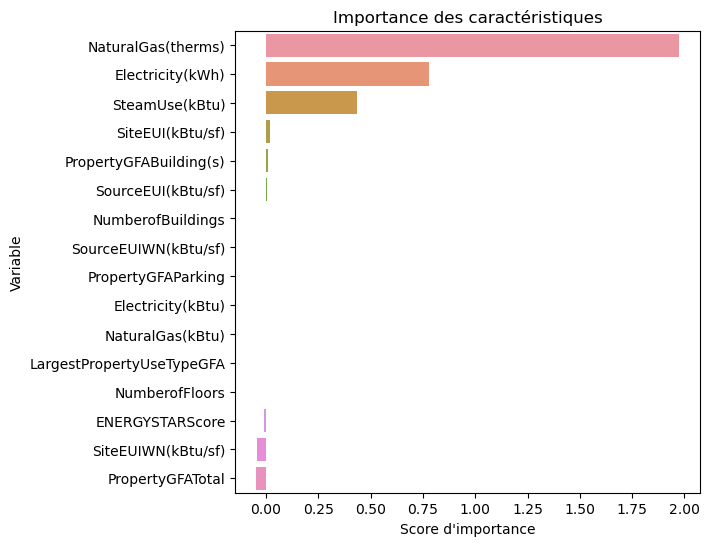

In [34]:
# perform permutation importance with permutation_importance class
importance_scores = permutation_importance(boosting_model, X_test, y_test, scoring='neg_mean_absolute_percentage_error').importances_mean

# Feature importance plot

feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score d'importance"] = []

for column,score in zip(X_train.columns,importance_scores):
    feature_importance_dict["Variable"].append(column)
    feature_importance_dict["Score d'importance"].append(score)

model_feature_importance = pd.DataFrame(feature_importance_dict).sort_values(by="Score d'importance",ascending=False)


plt.figure(figsize=(6,6))
plt.title("Importance des caractéristiques")
sns.barplot(y = model_feature_importance["Variable"],x=model_feature_importance["Score d'importance"])
plt.show()

In [35]:
# Metrics 
lin_list = [r2_score_lin,rmse_lin,mape_lin]
rf_list = [r2_rf,rmse_rf,mape_rf]
svr_list = [r2_svr,rmse_svr,mape_svr]
xgb_list = [r2_xgb,rmse_xgb,mape_xgb]
tableau = np.array([lin_list,rf_list,svr_list,xgb_list])
model_liste = [type(lin_model).__name__,type(grid_rf.best_estimator_).__name__,
               type(svm_model.best_estimator_).__name__,type(boosting_model.best_estimator_).__name__]

pd.DataFrame(tableau,model_liste,columns=["R2 Scores","RMSE","MAPE"]).sort_values(by="MAPE")

,R2 Scores,RMSE,MAPE
XGBRegressor,0.922182,0.098859,0.171940
SVR,0.778422,0.166818,0.182453
RandomForestRegressor,0.915122,0.103247,0.306277
LinearRegression,0.426781,0.268311,1.176550


- La MAPE(mean absolute pourcentage error) est la meilleure métrique pour comparer la performance de ces modèles de prédiction de l'émission de gaz à effet de serre entre-eux. 

**Conclusion** :
> Nous avons le modèle XGBRegressor comme notre modèle le plus performant pour la prédiction de l'émission de gaz à effet de serre des batiments non habitables de Seattle..

- Nous allons utiliser le modèle XGBRegressor pour le tester sur le jeu de données sans ENERGYSTARScore

# 2. Prédiction  de l'émission de CO2 sans ENERGYSTARScore avec le modèle de XGBRegressor avec GridSearchCV

- Notre meilleur modèle est le modèle Xgboost avec une gridsearch. Nous l'utilisons pour regarder sa performance quand on supprime la variable ENERGYSTARScore

In [60]:
# import the dataset without ENERGYSTARScore
seattle_data1 = pd.read_csv("without_energystarscore.csv")
seattle_data1.sample(5)

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
416,1.0,1,50417,0,50417,50417.0,36.599998,42.599998,73.900002,80.199997,1847401.000,2.149816e+06,0.0,2.505911e+05,855017.0,9923.839844,992384.0,58.67,1.16
663,1.0,2,21364,0,21364,15364.0,45.200001,52.000000,63.299999,71.400002,965651.125,1.110209e+06,0.0,4.754400e+04,162220.0,8034.310547,803431.0,43.80,2.05
591,1.0,6,95760,15840,79920,95760.0,56.299999,58.299999,159.399994,163.800003,5392617.500,5.587502e+06,0.0,1.346383e+06,4593859.0,7987.580078,798758.0,74.45,0.78
437,1.0,1,23000,0,23000,20310.0,30.900000,36.799999,56.099998,63.200001,711118.375,8.458922e+05,0.0,7.638880e+04,260639.0,4504.796875,450480.0,25.74,1.12
929,1.0,4,89391,0,89391,91694.0,60.799999,65.099998,150.399994,160.000000,5572010.000,5.964886e+06,0.0,1.113709e+06,3799975.0,17720.349610,1772035.0,120.60,1.35


In [61]:
# Standard scaling the predictor columns
# scale features
seattle_data_model1 = seattle_data1.copy()
scaler = StandardScaler()
seattle_data_model1.loc[:,seattle_data_model1.select_dtypes(include=[np.number]).columns.tolist()] = scaler.fit_transform(seattle_data_model.loc[:,seattle_data_model1.select_dtypes(include=[np.number]).columns.tolist()])

In [62]:
# Energy dataset without transformation of SiteEnergyUse(kBtu) target
seattle_ges_target = pd.DataFrame(seattle_data_model1['TotalGHGEmissions'])
seattle_ges_predictors = seattle_data_model1.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions',
                                                       "SiteEnergyUseWN(kBtu)","GHGEmissionsIntensity"], axis=1)

In [63]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(seattle_ges_predictors, seattle_ges_target, test_size=0.2)

print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_test',X_test.shape)
print('y_test',y_test.shape)

X_train (1354, 15)
y_train (1354, 1)
X_test (339, 15)
y_test (339, 1)


In [64]:
params = {'n_estimators' : [100,200,300,400,500,600,700]}
boosting_model1 = GridSearchCV(XGBRegressor(),param_grid=params,cv=5)
boosting_model1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'n_estimators': [100, 200, 300, 400, 500, 600, 700]})

In [65]:
# The coefficient of determination of the prediction.
r2_xgb = boosting_model1.score(X_test,y_test)
r2_xgb

0.9368748715077501

In [66]:
# make predictions on the data 
y_pred = boosting_model1.predict(X_test)

# RMSE est une mesure relative qui va dépendre de la valeur de la variable cible. Obtenir 2 RMSE différentes pour 2 sets 
    # de données et donc pour 2 modèles différents ne permet pas de conclure.
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_xgb

0.30659015992434474

In [67]:
# MAPE est une mesure relative mais indépendante de l'amplitude de la variable cible, donc une MAPE plus petite veut bien
 # dire un meilleur modèle.
mape_xgb1 = mean_absolute_percentage_error(y_test, y_pred)
mape_xgb1

0.11670516436871306

Text(0.5, 1.0, 'Ajustement du modèle XGBRegressor')

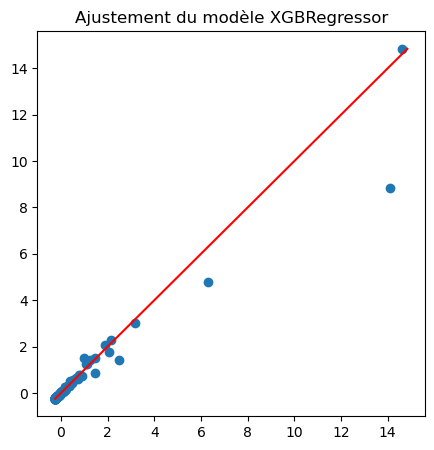

In [87]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred)
xmax = max(max(y_pred), float(max(np.array(y_test))))
xmin = min(min(y_pred), float(min(np.array(y_test))))
plt.plot([xmax, xmin], [xmax, xmin],'r')
plt.title(f"Ajustement du modèle {type(boosting_model1.best_estimator_).__name__}")

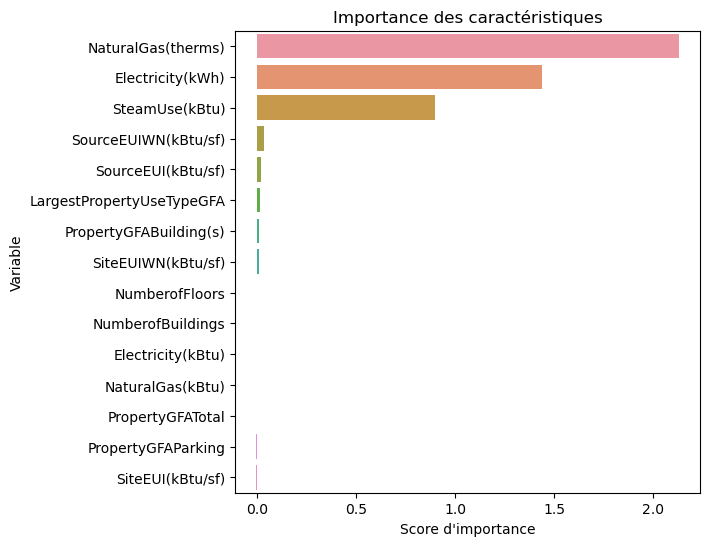

In [69]:
# perform permutation importance with permutation_importance class
importance_scores = permutation_importance(boosting_model1, X_test, y_test, scoring='neg_mean_absolute_percentage_error').importances_mean

# Feature importance plot

feature_importance_dict = {}
feature_importance_dict["Variable"] = []
feature_importance_dict["Score d'importance"] = []

for column,score in zip(X_train.columns,importance_scores):
    feature_importance_dict["Variable"].append(column)
    feature_importance_dict["Score d'importance"].append(score)

model_feature_importance = pd.DataFrame(feature_importance_dict).sort_values(by="Score d'importance",ascending=False)


plt.figure(figsize=(6,6))
plt.title("Importance des caractéristiques")
sns.barplot(y = model_feature_importance["Variable"],x=model_feature_importance["Score d'importance"])
plt.show()

In [85]:
# Metrics with the prediction without ENERGYSTARScore feature 
model_ = [type(boosting_model1.best_estimator_).__name__]
pd.DataFrame(np.array([[r2_xgb,rmse_xgb,mape_xgb1]]),model_,columns=["R2 Scores","RMSE","MAPE"])

,R2 Scores,RMSE,MAPE
XGBRegressor,0.936875,0.30659,0.116705


- Le modèle sans la variable ENERGYSTARScore est légèrement plus performant que celui en présence de la caractéristique ENERGYSTARScore car le MAPE(mean absolute percentage error) est plus petit.